In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk # just for tokenization
from nltk.corpus import stopwords
import random
import gradio 
random.seed(42)

# Milestones
1. Get the word2vec and glove vectors
2. Tokenize the lyrics corpus
3. Get the unique tokens and index them (not needed, may be)
4. Get word embeddings of each token in the lyrics, and do linear superposition every word vector to create a single vector for a lyric. Do this for all lyrics
5. Use clustering techniques 
    - Start with Kmeans for setting the baseline then try out other clustering techniques like DBSCAN.
6. Calculate the Silhoutte distance, WCSS for the model for comparison

# Loading Glove vectors

In [6]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin
wv_from_bin = load_embedding_model()
# wv_from_bin = load_embedding_model()

Loaded vocab size 3000000


# Vectorize the lyrics 

In [7]:
raw_df = pd.read_csv("../../Spotify Song Dataset.csv/million_songs.csv")

In [8]:
print(raw_df.head())
print(f"Number of songs {len(raw_df)}")

  artist                   song                                        link  \
0   ABBA  Ahe's My Kind Of Girl  /a/abba/ahes+my+kind+of+girl_20598417.html   
1   ABBA       Andante, Andante       /a/abba/andante+andante_20002708.html   
2   ABBA         As Good As New        /a/abba/as+good+as+new_20003033.html   
3   ABBA                   Bang                  /a/abba/bang_20598415.html   
4   ABBA       Bang-A-Boomerang      /a/abba/bang+a+boomerang_20002668.html   

                                                text  
0  Look at her face, it's a wonderful face  \nAnd...  
1  Take it easy with me, please  \nTouch me gentl...  
2  I'll never know why I had to go  \nWhy I had t...  
3  Making somebody happy is a question of give an...  
4  Making somebody happy is a question of give an...  
Number of songs 57650


In [10]:
len(raw_df["song"].unique()) # Name of the songs are not unique

44824

In [11]:
def tokenize(lyric: str) -> list[str]:
    # lowercase the text, remove stop words, punctuation and keep only the words
    tokens = nltk.tokenize.word_tokenize(lyric.lower())
    stop_words = stopwords.words("english")
    alpha_tokens = [token for token in tokens if (token.isalpha() and token not in stop_words)]
    return alpha_tokens

In [84]:
# go through each lyrics, tokenize it, vectorize each word, then combine all of them into single average vector and store it in the list
lyrics = raw_df["text"]
lyrics_embeddings = []
unsupported_tokens = set()
for lyric in tqdm(lyrics):
    lyric_vector = np.zeros(300)
    for token in tokenize(lyric):
        try:
            lyric_vector += wv_from_bin.get_vector(token.lower())
        except KeyError as e:
            # if the word is not present in the glove then key error is raised, so handle the exception and move on
            unsupported_tokens.add(token)
            continue
    lyrics_embeddings.append(lyric_vector)

lyrics_embeddings = np.stack(lyrics_embeddings)


100%|██████████| 57650/57650 [01:46<00:00, 541.51it/s]


In [12]:
# np.save("lyric_embeddins_01.npy", lyrics_embeddings)
lyrics_embeddings = np.load("lyric_embeddins_01.npy")

In [16]:
print(f"Embeddings shape {lyrics_embeddings.shape}, number of unsupported tokens {len(unsupported_tokens)}")
# scaling along each lyrics vector, for unit variance
scaled_lyrics_embeddings = lyrics_embeddings / np.linalg.norm(lyrics_embeddings, axis=1, keepdims=True)

# Clustering

## KMeans

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

In [17]:
# Number of clusters
k = 5

# Apply k-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(scaled_lyrics_embeddings)

c:\Users\shivs\anaconda3\envs\chess-engine\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5, random_state=42)

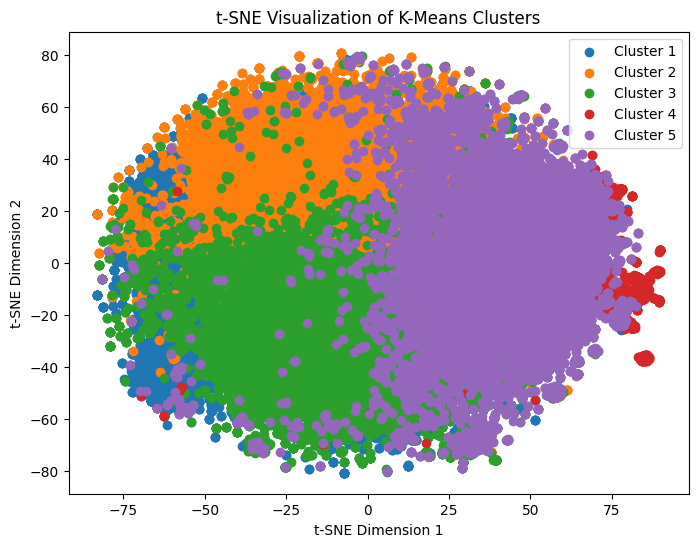

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Get cluster labels
cluster_labels = kmeans.labels_

# Apply t-SNE to reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
word_embeddings_tsne = tsne.fit_transform(scaled_lyrics_embeddings)

# Plot t-SNE visualization with cluster labels
plt.figure(figsize=(8, 6))
for i in range(k):
    plt.scatter(word_embeddings_tsne[cluster_labels == i, 0], 
                word_embeddings_tsne[cluster_labels == i, 1], 
                label=f'Cluster {i+1}')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of K-Means Clusters')
plt.legend()
plt.show()


In [18]:
closest_indices, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, scaled_lyrics_embeddings)

In [19]:
raw_df.loc[closest_indices]

,artist,song,link,text
26960,Cat Stevens,Foreigner Suite,/c/cat+stevens/foreigner+suite_20028113.html,"There are no words, I can use \nBecause the m..."
48526,Pitbull,Toma,/p/pitbull/toma_20358853.html,Oye Loca! Ven pa'ca! Come here! \nOye Loca! V...
37327,J Cole,The Autograph,/j/j+cole/the+autograph_20894859.html,"[J. Cole] \nThey say anythings possible, \nY..."
42933,Marillion,This Strange Engine,/m/marillion/this+strange+engine_20088964.html,There was a boy who came into this world \nAt...
34941,Guns N' Roses,Locomotive,/g/guns+n+roses/locomotive_10139577.html,Gonna find a way to cure this loneliness \nYe...


In [20]:
kmeans.cluster_centers_

array([[ 0.06009933,  0.03512105,  0.03036772, ..., -0.07031994,
         0.01035634,  0.00259082],
       [ 0.01272057,  0.04527636,  0.0515059 , ..., -0.07680484,
        -0.00864139,  0.05703552],
       [ 0.03733139,  0.03731658,  0.02175321, ..., -0.07696376,
         0.00519092,  0.00136227],
       [ 0.05475056,  0.05591603,  0.01970892, ..., -0.0513303 ,
         0.03064676, -0.00852016],
       [ 0.05014667,  0.03683962,  0.02519083, ..., -0.06138606,
         0.02507061, -0.02301422]])

In [ ]:
closest_indices_dict = {}
cluster_centers = kmeans.cluster_centers_

# Find the indices of the closest embeddings to each centroid
for i, centroid in enumerate(cluster_centers):
    # Calculate distances between centroid and all embeddings
    distances = np.linalg.norm(scaled_lyrics_embeddings - centroid, axis=1)
    # Sort distances and get indices of the closest 5 embeddings
    closest_indices = (-distances).argsort()[:10]
    # Store indices in dictionary
    closest_indices_dict[f'Centroid {i}'] = closest_indices


In [22]:
closest_indices_dict

{'Centroid 0': array([26960, 41931, 49198, 41928,  1272, 41988, 11453,  1727, 13192,
        20087], dtype=int64),
 'Centroid 1': array([48526, 41660,  6246, 54729, 55333, 20967, 48202, 36527, 48511,
        10121], dtype=int64),
 'Centroid 2': array([37327, 45718, 11541,  8848, 40148, 16474, 13038, 15931, 32245,
         8886], dtype=int64),
 'Centroid 3': array([42933,  1617, 40188, 25806, 25865, 10556, 15201, 25792, 42893,
         7359], dtype=int64),
 'Centroid 4': array([34941, 34925,  4572, 54674, 26314, 10521, 31403, 51834,  4542,
        14067], dtype=int64)}

In [43]:
raw_df.loc[closest_indices_dict["Centroid 0"]]

,artist,song,link,text
26960,Cat Stevens,Foreigner Suite,/c/cat+stevens/foreigner+suite_20028113.html,"There are no words, I can use \nBecause the m..."
41931,LL Cool J,I Need Love,/l/ll+cool+j/i+need+love_20081043.html,When I'm alone in my room \nSometimes I stare...
49198,Puff Daddy,Best Friend,/p/puff+daddy/best+friend_20112046.html,[Puffy] (Mario) \nI've seen a lot of things i...
41928,LL Cool J,I Can Give You More,/l/ll+cool+j/i+can+give+you+more_20172864.html,"I seen this girl, walking down the block \nI ..."
1272,Bee Gees,Above And Beyond,/b/bee+gees/above+beyond_20015664.html,Woman in a million to me \nI've never loved s...
41988,LL Cool J,You're In My Heart,/l/ll+cool+j/youre+in+my+heart_20627582.html,"Do you remember, the first time you fell in lo..."
11453,Leonard Cohen,Field Commander Cohen,/l/leonard+cohen/field+commander+cohen_2008282...,"Field Commander Cohen, he was our most importa..."
1727,Bon Jovi,Always,/b/bon+jovi/always_20022158.html,"This Romeo is bleeding, but you can't see his ..."
13192,Modern Talking,No. 1 Hit Medley,/m/modern+talking/no+1+hit+medley_20666841.html,Deep in my heart - there's a fire - a burning ...
20087,Underoath,And I Dreamt Of You,/u/underoath/and+i+dreamt+of+you_20188645.html,I see thy love in the distance \nBreathless g...


In [24]:
raw_df.loc[closest_indices_dict["Centroid 1"]]

,artist,song,link,text
48526,Pitbull,Toma,/p/pitbull/toma_20358853.html,Oye Loca! Ven pa'ca! Come here! \nOye Loca! V...
41660,Lil Wayne,How To Love Spanish,/l/lil+wayne/how+to+love+spanish_20982146.html,[Intro - lil wayne] \nCut the music up \nA l...
6246,Flo-Rida,Takeover,/f/flo+rida/takeover_21030376.html,"[Flo rida] verse 1 \nFlo Rida, Mizz Nina \nY..."
54729,Utada Hikaru,Hikari,/u/utada+hikaru/hikari_10162344.html,Donna toki datte \nTatta hitori de \nUnmei w...
55333,Vybz Kartel,Sweet To The Belly,/v/vybz+kartel/sweet+to+the+belly_20712743.html,Di gal go so \nIt sweet to di belly \nSqueez...
20967,Vybz Kartel,Robbery,/v/vybz+kartel/robbery_20694151.html,"This ain't serious, \nThis will make you deli..."
48202,Pharrell Williams,Where's Yours At?,/p/pharrell+williams/wheres+yours+at_20676412....,(feat. Rohff) \n \n[Chorus - Pharrell] \nWh...
36527,Iggy Pop,Squarehead,/i/iggy+pop/squarehead_20066942.html,You can kick me out of a real good jive \nYou...
48511,Pitbull,Oye Baby,/p/pitbull/oye+baby_20915414.html,"Nicola fasano, I hope I said that right \nMr...."
10121,Kate Bush,Prologue,/k/kate+bush/prologue_20573223.html,We're gonna be laughing about this \nWe're go...


In [25]:
raw_df.loc[closest_indices_dict["Centroid 2"]]

,artist,song,link,text
37327,J Cole,The Autograph,/j/j+cole/the+autograph_20894859.html,"[J. Cole] \nThey say anythings possible, \nY..."
45718,Nicki Minaj,Barbie World Intro,/n/nicki+minaj/barbie+world+intro_20873938.html,[Chorus:] \nI wanna get to know you \nI real...
11541,Lil Wayne,Breakin' My Heart,/l/lil+wayne/breakin+my+heart_20663244.html,(feat. Little Brother) \n \nHey baby look he...
8848,J Cole,Back To The Topic,/j/j+cole/back+to+the+topic_20894721.html,"Yea, n-gga \nI'm gon ahead and murder this sh..."
40148,Kid Rock,I Am The Bullgod,/k/kid+rock/i+am+the+bullgod_20078137.html,[Chorus] \nI am the Bullgod \nI am free and ...
16474,Puff Daddy,I Want You Back '98 (Bad Boy Mix),/p/puff+daddy/i+want+you+back+98+bad+boy+mix_2...,[Puff Intro] \nYeah \nThe old school \nTo t...
13038,Michael Jackson,I Want You Back '98,/m/michael+jackson/i+want+you+back+98_20722774...,[Puff Intro] \nYeah \nThe old school \nTo t...
15931,Pharrell Williams,How Does It Feel?,/p/pharrell+williams/how+does+it+feel_20480163...,Wooo wooo! [in background] \nYessur! aha \nN...
32245,Fabolous,Can't Let You Go,/f/fabolous/cant+let+you+go_20052278.html,Baby girl \nYou know my situation \nAnd some...
8886,J Cole,You Got It,/j/j+cole/you+got+it_20969036.html,"[Refrain: \nHey one time, hey one time \nOne..."


In [26]:
raw_df.loc[closest_indices_dict["Centroid 3"]]

,artist,song,link,text
42933,Marillion,This Strange Engine,/m/marillion/this+strange+engine_20088964.html,There was a boy who came into this world \nAt...
1617,Bob Dylan,Floater,/b/bob+dylan/floater_10043295.html,Down over the window \nFrom the dazzling sunl...
40188,The Killers,A Dustland Fairytale,/k/killers/a+dustland+fairytale_20768319.html,Dustland fairytale beginning \nJust another w...
25806,Bob Dylan,Dreamin' Of You,/b/bob+dylan/dreamin+of+you_20750947.html,The light \nIn this place \nIs really bad \...
25865,Bob Dylan,Idiot Wind,/b/bob+dylan/idiot+wind_20021193.html,"Someone's got it in for me, they're planting s..."
10556,The Killers,Tranquilize,/k/killers/tranquilize_20656065.html,"Time it tells living in my home town, \nWeddi..."
15201,Out Of Eden,No Turning Back,/o/out+of+eden/no+turning+back_20835308.html,[Rap by Knowdaverbs:] \nI remember begging my...
25792,Bob Dylan,'Cross The Green Mountain,/b/bob+dylan/cross+the+green+mountain_20175524...,I cross the green mountain \nI sit by the str...
42893,Marillion,Living With The Big Lie,/m/marillion/living+with+the+big+lie_20088826....,It all began with the bright light \nThe brig...
7359,Hank Snow,Come The Morning,/h/hank+snow/come+the+morning_20170801.html,I sit upon the bed in my rented room and watch...


In [27]:
raw_df.loc[closest_indices_dict["Centroid 4"]]

,artist,song,link,text
34941,Guns N' Roses,Locomotive,/g/guns+n+roses/locomotive_10139577.html,Gonna find a way to cure this loneliness \nYe...
34925,Guns N' Roses,Coma,/g/guns+n+roses/coma_10139584.html,See you've caught me in a coma \nAnd I don't ...
4572,Dream Theater,Space-Dye Vest,/d/dream+theater/space+dye+vest_20043326.html,Falling through pages of Martens on angels \n...
54674,Usher,Here I Stand,/u/usher/here+i+stand_20741871.html,[Verse 1] \nI'm hoping that this ain't too ha...
26314,Bonnie Raitt,Steal Your Heart Away,/b/bonnie+raitt/steal+your+heart+away_20022605...,I know you got a different picture in mind \n...
10521,Kid Rock,My Oedipus Complex,/k/kid+rock/my+oedipus+complex_20078203.html,I need somebody won't you help me \nI need so...
31403,Eminem,Her Song,/e/eminem/her+song_21093870.html,[Chorus] \nWrap me in a bolt of lightning \n...
51834,Snoop Dogg,I Believe In You,/s/snoop+dogg/i+believe+in+you_20127137.html,[Latoiya Williams] \nI'm so glad that you bel...
4542,Drake,The Resistance,/d/drake/the+resistance_20884830.html,"Yesterday when we were getting high, you were ..."
14067,Nicki Minaj,All Things Go,/n/nicki+minaj/all+things+go_21091474.html,"[Verse 1] \nYo, I had to reinvent, I put the ..."


In [28]:
def vectorise(lyrics: str) -> np.array:
    tokens = tokenize(lyrics)
    lyric_vector = np.zeros(300)
    for token in tokens:
        try:
            lyric_vector += wv_from_bin.get_vector(token.lower())
        except:
            continue
    return lyric_vector / np.linalg.norm(lyric_vector)
    

In [29]:
set(kmeans.labels_)

{0, 1, 2, 3, 4}

In [30]:
raw_df.loc[raw_df["song"] == "Beat It"]

,artist,song,link,text
13016,Michael Jackson,Beat It,/m/michael+jackson/beat+it_20092702.html,They told him don't you ever come around here ...
32449,Fall Out Boy,Beat It,/f/fall+out+boy/beat+it_20726334.html,They told him don't you ever come around here ...


In [34]:
song = """f you wanna run away with me, I know a galaxy
And I can take you for a ride
I had a premonition that we fell into a rhythm
Where the music don't stop for life
Glitter in the sky, glitter in my eyes
Shining just the way I like
If you're feeling like you need a little bit of company
You met me at the perfect time
You want me, I want you, baby
My sugarboo, I'm levitating
The Milky Way, we're renegading
Yeah, yeah, yeah, yeah, yeah
I got you, moonlight, you're my starlight
I need you all night, come on, dance with me
I'm levitating
You, moonlight, you're my starlight (you're the moonlight)
I need you all night, come on, dance with me
I'm levitating
I believe that you're for me, I feel it in our energy
I see us written in the stars
We can go wherever, so let's do it now or never, baby
Nothing's ever, ever too far
Glitter in the sky, glitter in our eyes
Shining just the way we are
I feel like we're forever, every time we get together
But whatever, let's get lost on Mars
You want me, I want you, baby
My sugarboo, I'm levitating
The Milky Way, we're renegading
Yeah, yeah, yeah, yeah, yeah
I got you, moonlight, you're my starlight
I need you all night, come on, dance with me
I'm levitating
You, moonlight, you're my starlight (you're the moonlight)
I need you all night, come on, dance with me
I'm levitating (whoo)
You can fly away with me tonight
You can fly away with me tonight
Baby, let me take you for a ride
Yeah, yeah, yeah, yeah, yeah
I'm levitating (whoo)
You can fly away with me tonight
You can fly away with me tonight
Baby, let me take you for a ride
Yeah, yeah, yeah, yeah, yeah (whoo)
My love is like a rocket, watch it blast off
And I'm feeling so electric, dance my arse off
And even if I wanted to, I can't stop
Yeah, yeah, yeah, yeah, yeah
My love is like a rocket, watch it blast off
And I'm feeling so electric, dance my arse off
And even if I wanted to, I can't stop
Yeah, yeah, yeah, yeah, yeah
You want me, I want you, baby
My sugarboo, I'm levitating
The Milky Way, we're renegading
I got you (yeah), moonlight, you're my starlight
I need you all night (all night), come on, dance with me
I'm levitating (whoo)
You can fly away with me tonight (tonight)
You can fly away with me tonight
Baby, let me take you for a ride
Yeah, yeah, yeah, yeah, yeah (take you for a ride)
I'm levitating (whoo)
You can fly away with me tonight (tonight)
You can fly away with me tonight
Baby, let me take you for a ride
Yeah, yeah, yeah, yeah, yeah (let me take you for a ride)
I got you, moonlight, you're my starlight (you are my starlight)
I need you all night, come on, dance with me (come on, dance with me, baby)
I'm levitating
You, moonlight, you're my starlight (you're the moonlight)
I need you all night, come on, dance with me
I'm levitating"""
kmeans.predict([vectorise(song)])

array([2])

In [32]:
def predict(lyrics: str) -> str:
    return kmeans.predict([vectorise(lyrics)])

In [40]:
import gradio as gr
# Create Gradio interface with dropdown menu
inputs = gr.Textbox(label="Input Lyrics")
model_dropdown = gr.Dropdown(choices=["KMEANS", "DBSCAN"], label="Select Model")
outputs = gr.Textbox(label="Sentiment/Mood")
interface = gr.Interface(fn=predict, inputs=[inputs, model_dropdown], outputs=outputs)
interface.launch()

c:\Users\shivs\anaconda3\envs\chess-engine\lib\site-packages\gradio\utils.py:843: UserWarning: Expected 1 arguments for function <function predict at 0x0000018A1BAF1EA0>, received 2.
  warnings.warn(
c:\Users\shivs\anaconda3\envs\chess-engine\lib\site-packages\gradio\utils.py:851: UserWarning: Expected maximum 1 arguments for function <function predict at 0x0000018A1BAF1EA0>, received 2.
  warnings.warn(


Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.
